In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

Adapted from https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65. Edited to use gradient descent variations.

In [ ]:
# activation functions and derivatives
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2

def relu(x):
    # x is a numpy array
    return np.maximum(np.zeros(np.size(x)), x)

def relu_prime(x):
    answ = relu(x)
    answ[answ!=0] = 1
    return answ

# activation functions
def sigmoid(x):
    # x is a numpy array
    return 1 / (1 + np.power(np.e, -x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [ ]:
# loss functions and derivatives
mach_ep = np.finfo(float).eps

# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

def cross_entropy(y_true, y_pred):
    return -1*(y_true*np.log(y_pred + mach_ep) + (1-y_true)*np.log(1-y_pred + mach_ep))

def cross_entropy_prime(y_true, y_pred):
    return y_pred - y_true
    #return -1*(np.mean(np.log(y_pred + mach_ep) - np.log(1-y_pred + mach_ep)))

In [ ]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate = 0.001, variation="stochastic", decay_rate = 0.9, beta1 = 0.9, beta2 = 0.999,                               
                             prev_sum_of_gradient_weights = None, prev_sum_of_gradient_weights_squared = None,                               
                             prev_sum_of_gradient_bias = None, prev_sum_of_gradient_bias_squared = None, n=1):
      #variation: [stochastic, momentum, adagrad, rmsprop, adam]
      #decay rate relevent to momentum, adagrad, rmsprop
      #beta1, beta2 relevant to adam
        raise NotImplementedError

In [ ]:
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        np.random.seed(1)
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate, variation="stochastic", decay_rate = 0.9, beta1 = 0.9, beta2 = 0.999,
                                   prev_sum_of_gradient_weights = None, prev_sum_of_gradient_weights_squared = None,                               
                                   prev_sum_of_gradient_bias = None, prev_sum_of_gradient_bias_squared = None, n=1):
        
        sum_of_gradient_weights, sum_of_gradient_weights_squared, sum_of_gradient_bias, sum_of_gradient_bias_squared = 0,0,0,0
        ep = 10**(-8)

        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)

        # update parameters; depends on gradient descent variation
        if(variation == "stochastic"):
            weight_delta = -learning_rate * weights_error
            self.weights += weight_delta
            bias_delta = -learning_rate * output_error
            self.bias += bias_delta
        elif(variation=="momentum"):
            #update weights
            sum_of_gradient_weights = weights_error + prev_sum_of_gradient_weights * decay_rate
            weight_delta = -learning_rate * sum_of_gradient_weights
            self.weights += weight_delta
            #update biases
            sum_of_gradient_bias = output_error + prev_sum_of_gradient_bias * decay_rate
            bias_delta = -learning_rate * sum_of_gradient_bias
            self.bias += bias_delta
        elif(variation == "adagrad"):
            #update weights
            sum_of_gradient_weights_squared = prev_sum_of_gradient_weights_squared + np.power(weights_error, 2)
            weight_delta = -learning_rate * (weights_error / (np.sqrt(sum_of_gradient_weights_squared) + ep))
            self.weights += weight_delta
            #update biases
            sum_of_gradient_bias_squared = prev_sum_of_gradient_bias_squared + np.power(output_error, 2)
            bias_delta = -learning_rate * (output_error / (np.sqrt(sum_of_gradient_bias_squared) + ep))
            self.bias += bias_delta
        elif(variation == "rmsprop"):
            #update weights
            sum_of_gradient_weights_squared = (prev_sum_of_gradient_weights_squared * decay_rate) + (np.power(weights_error,2) * (1-decay_rate)) + ep
            weight_delta = -learning_rate * weights_error / np.sqrt(sum_of_gradient_weights_squared)
            self.weights += weight_delta
            #update biases
            sum_of_gradient_bias_squared = (prev_sum_of_gradient_bias_squared * decay_rate) + (np.power(output_error,2) * (1-decay_rate)) + ep
            bias_delta = -learning_rate * output_error / np.sqrt(sum_of_gradient_bias_squared)
            self.bias += bias_delta
        elif(variation == "adam"):
            #update weights
            sum_of_gradient_weights = (prev_sum_of_gradient_weights * beta1) + (weights_error * (1-beta1))
            sum_of_gradient_weights_squared = (prev_sum_of_gradient_weights_squared * beta2) + (np.power(weights_error,2) * (1-beta2)) + ep
            bias_corrected_sum_of_gradient_weights = sum_of_gradient_weights / (1-(beta1**n))
            bias_corrected_sum_of_gradient_weights_squared = sum_of_gradient_weights_squared / (1-(beta2**n))
            weight_delta = -learning_rate * (bias_corrected_sum_of_gradient_weights/np.sqrt(bias_corrected_sum_of_gradient_weights_squared))
            self.weights += weight_delta
            #update biases
            sum_of_gradient_bias = (prev_sum_of_gradient_bias * beta1) + (output_error * (1-beta1))
            sum_of_gradient_bias_squared = (prev_sum_of_gradient_bias_squared * beta2) +  (np.power(output_error, 2) * (1-beta2)) + ep
            bias_corrected_sum_of_gradient_biases = sum_of_gradient_bias / (1-(beta1**n))
            bias_corrected_sum_of_gradient_biases_squared = sum_of_gradient_bias_squared / (1-(beta2**n))
            bias_delta = -learning_rate * (bias_corrected_sum_of_gradient_biases/np.sqrt(bias_corrected_sum_of_gradient_biases_squared))
            self.bias += bias_delta
        else:
            print("not a valid gradient descent variant")
        return input_error, sum_of_gradient_weights, sum_of_gradient_weights_squared, sum_of_gradient_bias, sum_of_gradient_bias_squared


In [ ]:
# inherit from base class Layer
# adding this layer between hidden layers to apply activation function. Note that for forward propagation literally 
# just applies the function
# For backpropagation takes the derivative of the inputs and multiplies (element wise) by cost
# note that guarenteed same dimensions because the activation layer and the hidden layer are basically the same thing
# just with this function applied... could include the activation function in the hidden layer too?
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate = 0.001, variation="stochastic", decay_rate = 0.9, beta1 = 0.9, beta2 = 0.999, prev_sum_of_gradient_weights = None, prev_sum_of_gradient_weights_squared = None, prev_sum_of_gradient_bias = None, prev_sum_of_gradient_bias_squared = None, n=1):
        return self.activation_prime(self.input) * output_error, prev_sum_of_gradient_weights, prev_sum_of_gradient_weights_squared, prev_sum_of_gradient_bias, prev_sum_of_gradient_bias_squared


In [ ]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        #use bayes rule to recalibrate the outputs based on false positive / negative rates...
        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate=0.1, variation="stochastic"):
        # sample dimension first
        samples = len(x_train)

        #matrix to store previous gradients for each layer (stored in reverse order)
        prev_gradients = np.zeros([len(self.layers), 4], dtype="object")

        #keep track of average error over each epoch 
        errors = []

        # training loop
        for n in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for i, layer in enumerate(reversed(self.layers)):
                    error, prev_grad_weights, prev_grad_weights_squared, prev_grad_bias, prev_grad_bias_squared = layer.backward_propagation(error, learning_rate, variation = variation, prev_sum_of_gradient_weights = prev_gradients[i][0],
                                                prev_sum_of_gradient_weights_squared = prev_gradients[i][1],
                                                prev_sum_of_gradient_bias = prev_gradients[i][2], prev_sum_of_gradient_bias_squared = prev_gradients[i][3], n=n+1)
                    prev_gradients[i][0] = prev_grad_weights
                    prev_gradients[i][1] = prev_grad_weights_squared
                    prev_gradients[i][2] = prev_grad_bias
                    prev_gradients[i][3] = prev_grad_bias_squared

            # calculate average error on all samples
            err /= samples
            errors.append(err)
            #print('epoch %d/%d   error=%f' % (n+1, epochs, err))
        return errors

## Test with XOR

In [ ]:
# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(sigmoid, sigmoid_prime))

# train
net.use(cross_entropy, cross_entropy_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.1, variation="momentum")

# test
out = net.predict(x_train)
print(out)

[array([[0.0490405]]), array([[0.94745485]]), array([[0.9433634]]), array([[0.0711281]])]


## Testing and Visualization with Breast Cancer Data

In [ ]:
#breast cancer data

df = pd.read_csv("https://raw.githubusercontent.com/UBC-MDS/DSCI_522_Breast_cancer_predictors/master/data/breast_cancer_data.csv")
df_means = df.iloc[:, range(0,12)].copy()
df_se = df.iloc[:, [0,1] + list(range(12,22))]
df_worst = df.iloc[:, [0,1] + list(range(23,32))]

In [ ]:
df_means.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [ ]:
# replace B with 0 and M with 1

df_means.loc[list(df_means['diagnosis'] == 'B'), 'diagnosis'] = 0
df_means.loc[list(df_means['diagnosis'] == 'M'), 'diagnosis'] = 1

In [ ]:
#split dataset. 80% training and 20% testing

indices = list(range(0, len(df_means)))
random.shuffle(indices)

train_indices = indices[0:int(len(indices)*0.8)]

test_indices = list(set(indices) - set(train_indices))

training = df_means.iloc[train_indices]
testing = df_means.iloc[test_indices]



stochastic:
Accuracy: 0.9473684210526315
True Positive: 40
True Negative: 68
False Positive: 2
False Negative: 4

momentum:
Accuracy: 0.956140350877193
True Positive: 40
True Negative: 69
False Positive: 1
False Negative: 4

adagrad:
Accuracy: 0.9473684210526315
True Positive: 40
True Negative: 68
False Positive: 2
False Negative: 4

rmsprop:
Accuracy: 0.9385964912280702
True Positive: 39
True Negative: 68
False Positive: 2
False Negative: 5

adam:
Accuracy: 0.9385964912280702
True Positive: 40
True Negative: 67
False Positive: 3
False Negative: 4



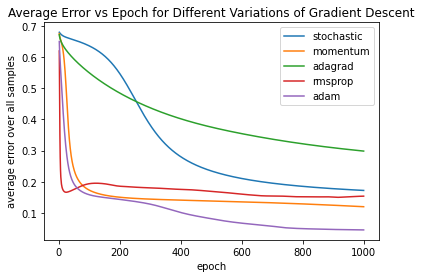

In [ ]:
for i in ['stochastic', 'momentum', 'adagrad', 'rmsprop', 'adam']:
      #set best paramaters for each method (determined by CV)
      if i == 'stochastic':
        h1 = 18
        h2 = 8
        alpha = 0.001
      if i =='momentum':
        h1 = 18
        h2 = 8
        #alpha = 0.0001
        alpha = 0.001
      if i =='adagrad':
        h1 = 18
        h2 = 8
        #alpha = 0.01
        alpha = 0.001
      if i =='rmsprop':
        h1 = 18
        h2 = 8
        alpha = 0.001
      if i =='adam':
        h1 = 18
        h2 = 8
        alpha = 0.001


      # training data
      x_train = np.array(training.iloc[:, 2:].values.tolist())
      x_train = np.expand_dims(x_train, axis=1)
      training_mean = np.mean(x_train, axis = 0)
      training_std = np.std(x_train, axis = 0)
      x_train = (x_train - training_mean) / training_std
      y_train = np.array(list(map(lambda el:[el], training.iloc[:, 1].values)))
      y_train = np.expand_dims(y_train, axis=1)

      # testing data
      x_test = np.array(testing.iloc[:, 2:].values.tolist())
      x_test = np.expand_dims(x_test, axis=1)
      x_test = (x_test - training_mean) / training_std
      y_test = np.array(list(map(lambda el:[el], testing.iloc[:, 1].values)))
      y_test = np.expand_dims(y_test, axis=1)

      # network; use cross entropy loss because binary classifer. use sigmoid because cross entropy
      # loss requires a probabalistic activation function
      net = Network()
      net.add(FCLayer(10, h1))
      net.add(ActivationLayer(sigmoid, sigmoid_prime))
      net.add(FCLayer(h1, h2))
      net.add(ActivationLayer(sigmoid, sigmoid_prime))
      net.add(FCLayer(h2, 1))
      net.add(ActivationLayer(sigmoid, sigmoid_prime))

      # train
      net.use(cross_entropy, cross_entropy_prime)
      errors = net.fit(x_train, y_train, epochs=1000, learning_rate=alpha, variation=i)

      # test
      out = net.predict(x_test)

      #find number of same values
      num_same = 0
      num_diff = 0
      for j in range(0, len(out)):
          if np.around(out[j]) == y_test[j]:
              num_same += 1
          else:
              num_diff += 1
          
      print(i + ":")
      print("Accuracy: " + str(num_same / (len(out))))

      #find false/true pos/neg rates
      true_pos = 0
      true_neg = 0
      false_pos = 0
      false_neg = 0

      for j in range(0, len(out)):
        if np.around(out[j]) == 1 and y_test[j] == 1:
          true_pos += 1
        elif np.around(out[j]) == 1 and y_test[j] == 0:
          false_pos += 1
        elif np.around(out[j]) == 0 and y_test[j] == 0:
          true_neg += 1
        else:
          false_neg += 1
      
      print("True Positive: " + str(true_pos))
      print("True Negative: " + str(true_neg))
      print("False Positive: " + str(false_pos))
      print("False Negative: " + str(false_neg))
      print()

      #plot errors over epoch
      x = range(1,1001)
      y = [n[0][0] for n in errors]

      plt.plot(x,y, label = i)
  
plt.legend()
plt.xlabel('epoch')
plt.ylabel('average error over all samples')
plt.title('Average Error vs Epoch for Different Variations of Gradient Descent')
plt.show()
      